In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

device = torch.device("mps") # Using hardware acceleration on Mac M2!!

Loading dataset

In [2]:
# Writing a dataloader to load image data from ../data/ folder

class DASImageDataset(Dataset):
    def __init__(self, root_dir, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.files = os.listdir(self.root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_file =(os.path.join(self.root_dir, self.files[index]))
        img = Image.open(img_file)
        
        if self.transform:
            img = self.transform(img)
        
        return img, self.files[index]

In [3]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

images = DASImageDataset(root_dir='../data/processed_clip1k_fs100_bpf1435/', transform=transform)
train_len = int(0.8 * len(images))
test_len = len(images) - train_len

train_dataset, test_dataset = random_split(images, [train_len, test_len])

train_dataloader = DataLoader(train_dataset, batch_size=32, sampler=RandomSampler(train_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=32, sampler=RandomSampler(test_dataset))


In [4]:
def view_batch(batch):
    grid = make_grid(batch, nrow=8, padding=5)
    plt.figure(figsize=(20,10))
    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.show()

def view_image(img):
    img = img.squeeze()
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.show()

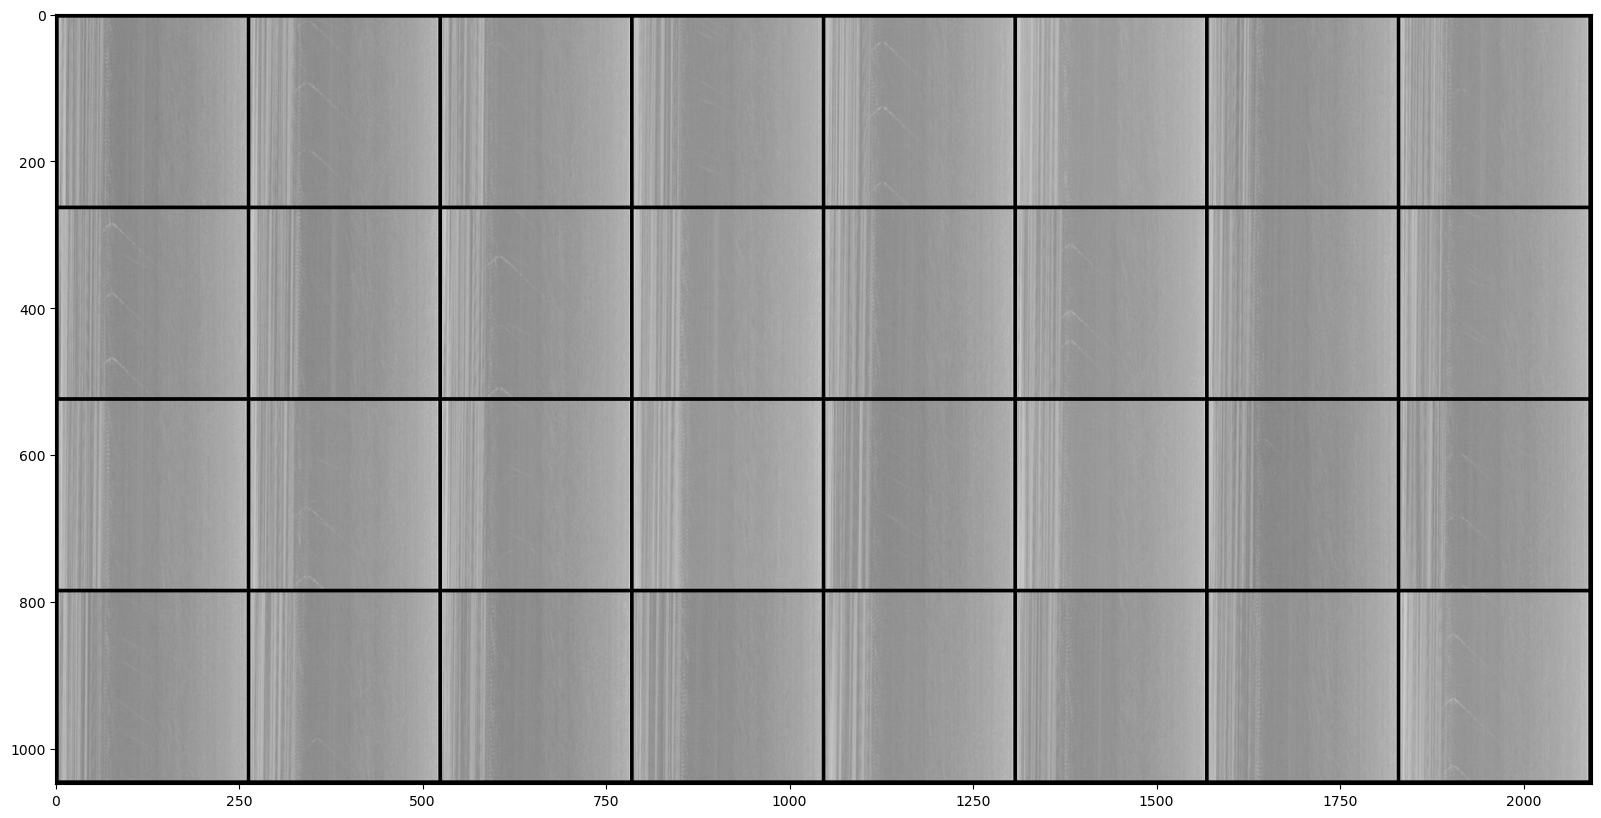

In [5]:
for images, _ in train_dataloader:
    view_batch(images)
    break

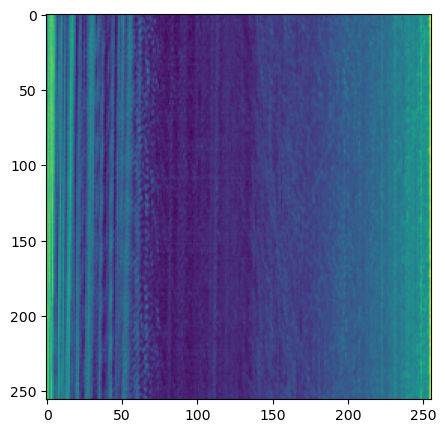

In [6]:
view_image(images[torch.randint(0, len(images), (1,))])

Building model

In [102]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 16, stride=2, padding=7), # (256 - 16 + 2*7)/2 + 1 = 128
            nn.ReLU(True),
            nn.Conv2d(8, 16, 16, stride=2, padding=7), # (128 - 16 + 2*7)/2 + 1 = 64
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 16, stride=2, padding=7), # 
            nn.ReLU(True),
            nn.Conv2d(32, 64, 16, stride=2, padding=7), # (32 - 16 + 2*7)/2 + 1 = 16
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 16, stride=2, padding=7), # (16 - 14 + 2*1)/2 + 1 = 8
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(8 * 8 * 128, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, fc2_input_dim),
            nn.ReLU(True),
            nn.Linear(fc2_input_dim, 8 * 8 * 128),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(128, 8, 8))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 16, stride=2, padding=7), #
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 16, stride=2, padding=7), # (16 - 1)*2 - 2*1 + 4 = 32
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 16, stride=2, padding=7), # (32 - 1)*2 - 2*1 + 4 = 64
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 16, stride=2, padding=7), # (64 - 1)*2 - 2*1 + 4 = 128
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 16, stride=2, padding=7) # (128 - 1)*2 - 2*1 + 4 = 256
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [103]:
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer, verbose=True):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the file names (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        if verbose:
            print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data



In [104]:
def plot_ae_outputs(encoder,decoder,dataset,n=10):
    plt.figure(figsize=(16,4.5))
    # targets = test_dataset.targets.numpy()
    # t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    t_idx = np.random.randint(0,len(dataset),n)
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = dataset[t_idx[i]][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show() 

EPOCH 10 of 100 	 train loss 0.0015033903764560819 	 val loss 0.001331256004050374


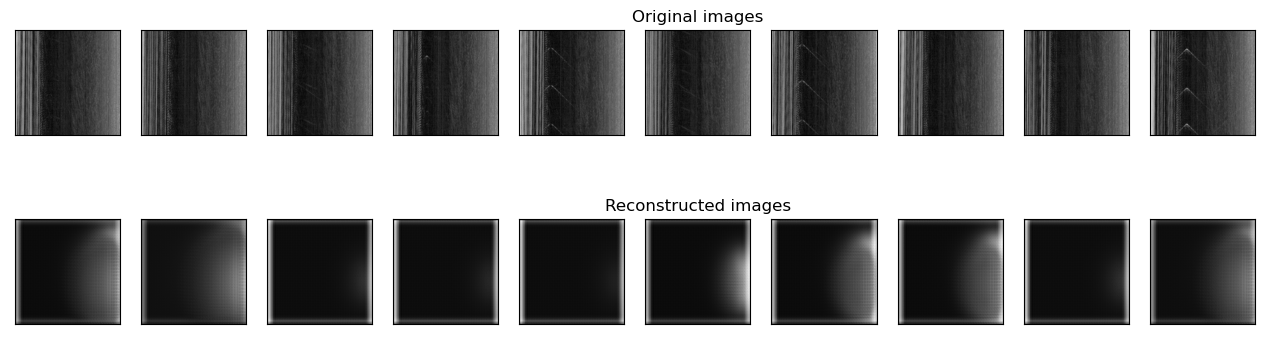

EPOCH 20 of 100 	 train loss 0.0006015317630954087 	 val loss 0.0007569675799459219


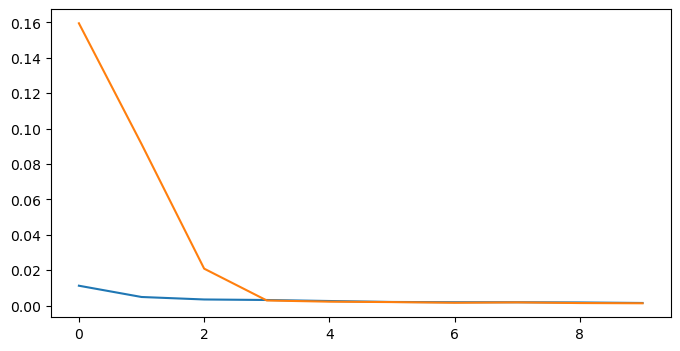

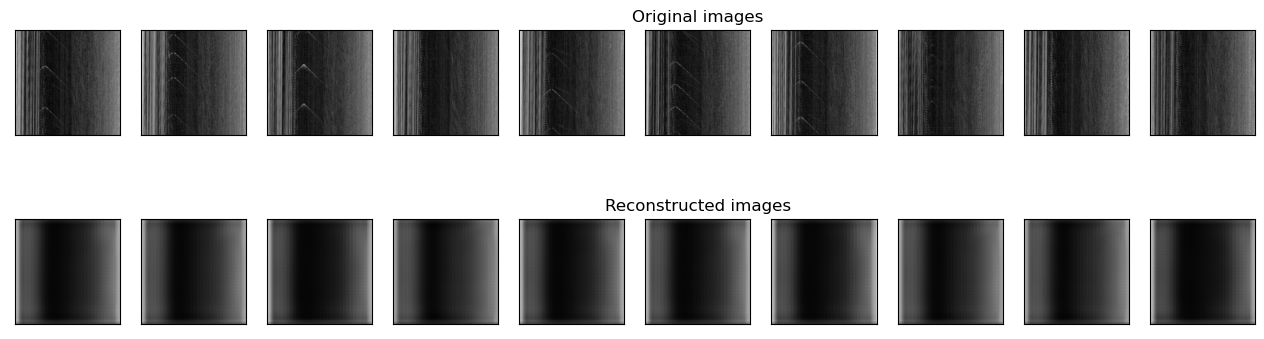

EPOCH 30 of 100 	 train loss 0.0005968246841803193 	 val loss 0.0005223230691626668


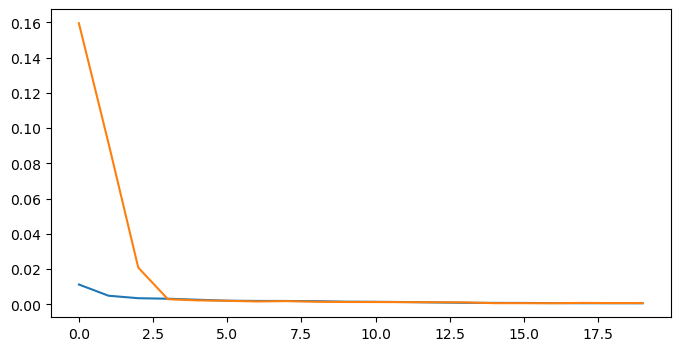

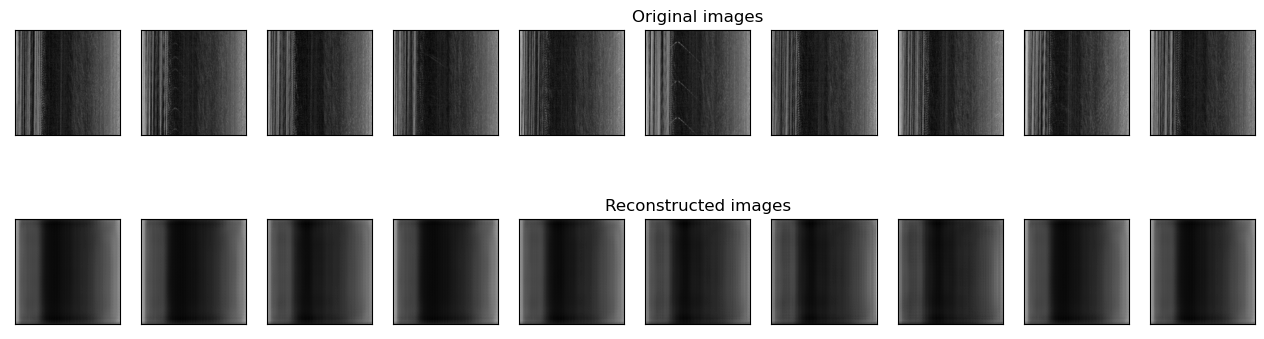

EPOCH 40 of 100 	 train loss 0.0005182164022698998 	 val loss 0.0005219578742980957


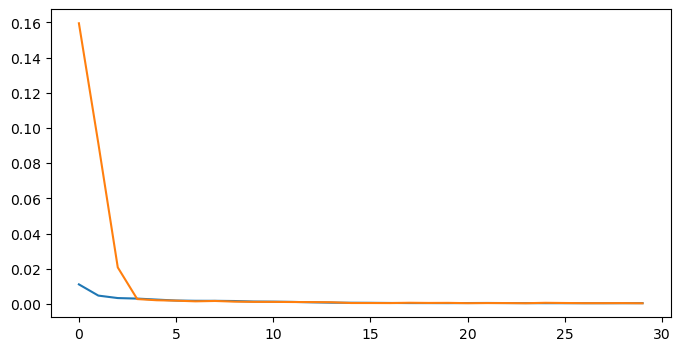

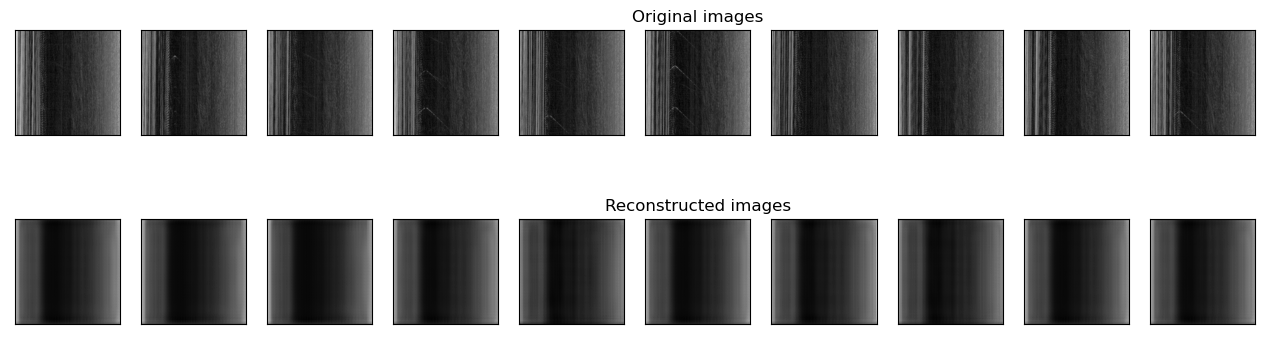

EPOCH 50 of 100 	 train loss 0.000528472475707531 	 val loss 0.0004942670348100364


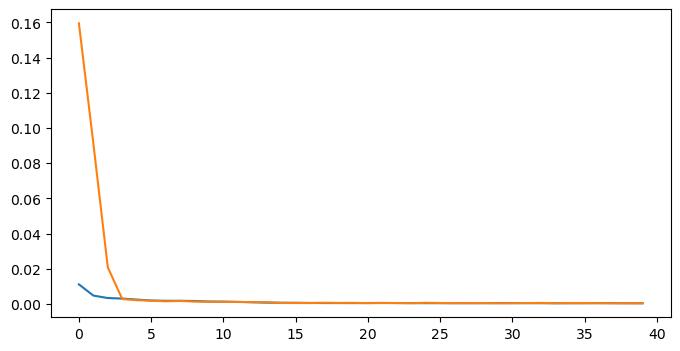

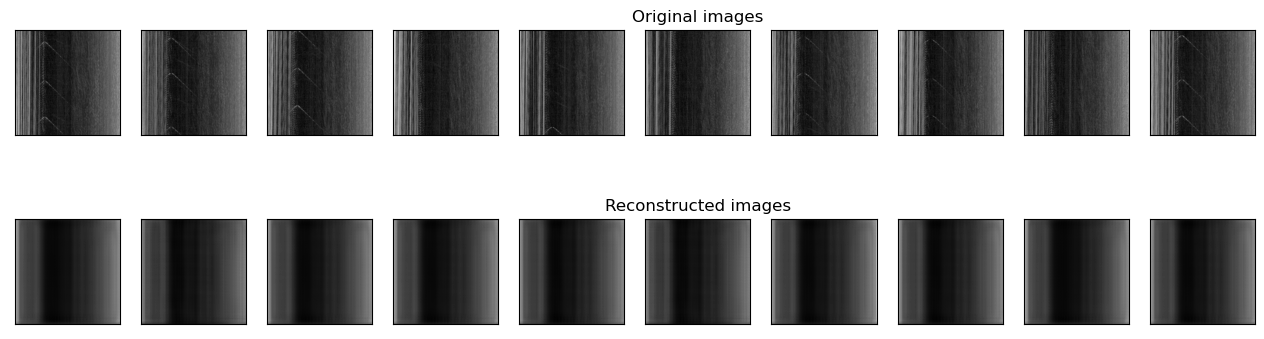

EPOCH 60 of 100 	 train loss 0.000508706783875823 	 val loss 0.0005193916149437428


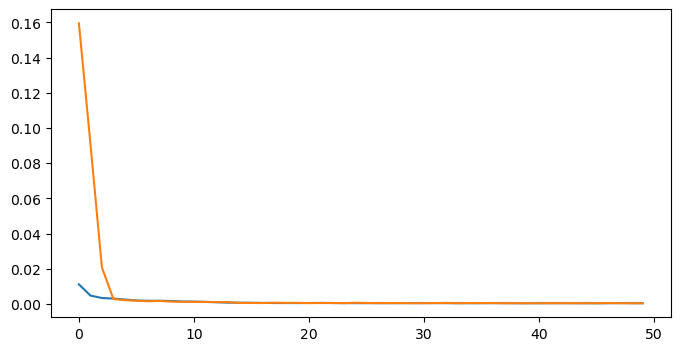

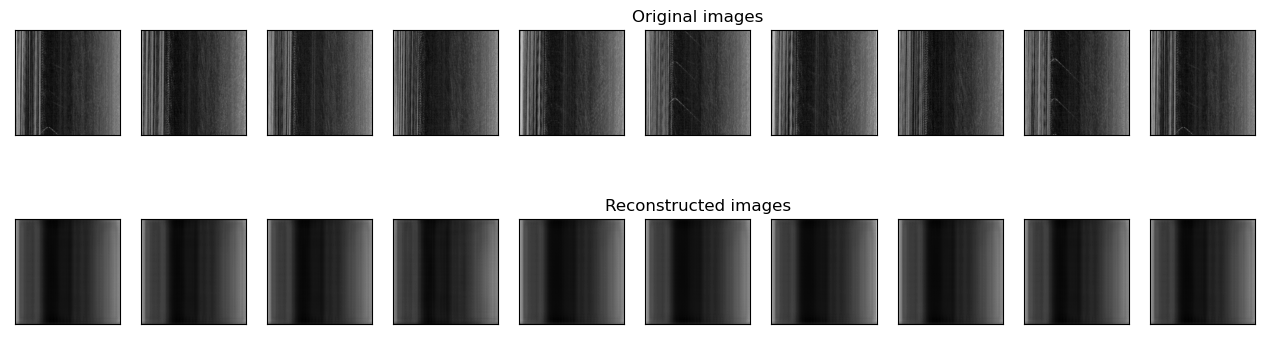

EPOCH 70 of 100 	 train loss 0.0005022374680265784 	 val loss 0.0004925575922243297


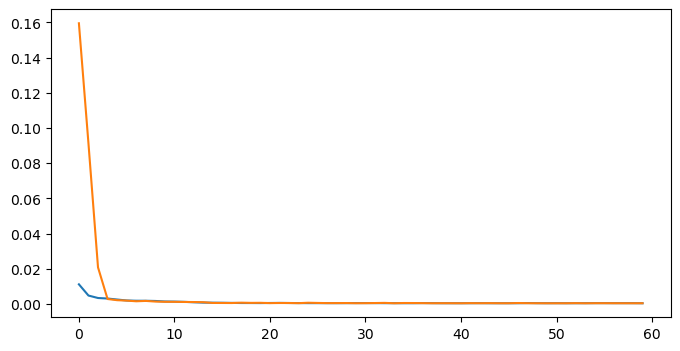

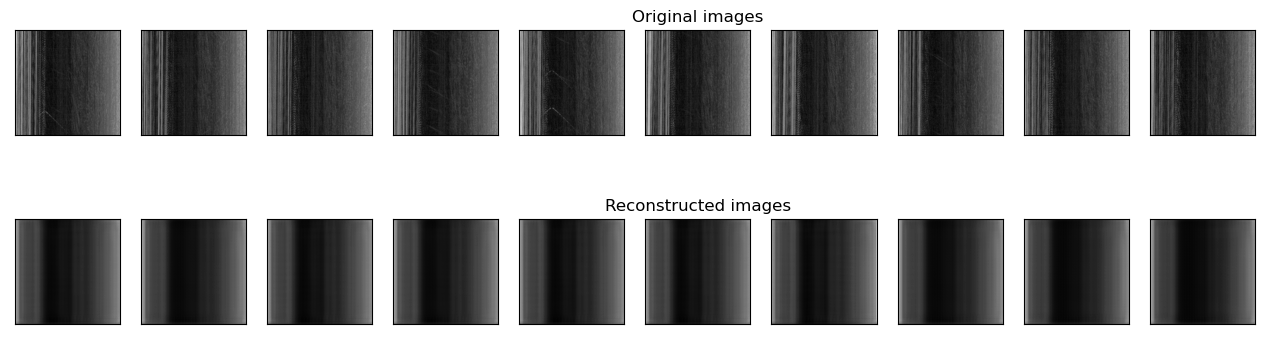

EPOCH 80 of 100 	 train loss 0.0005031643086113036 	 val loss 0.0004947923007421196


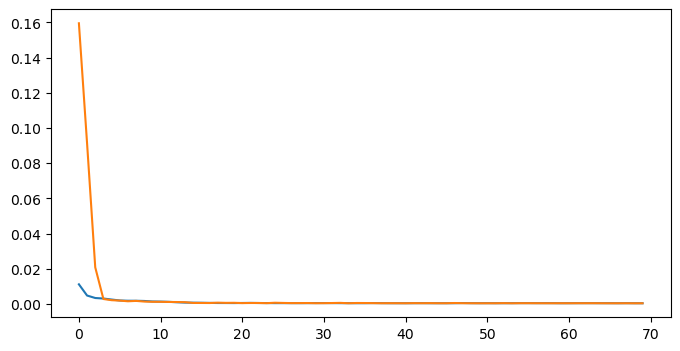

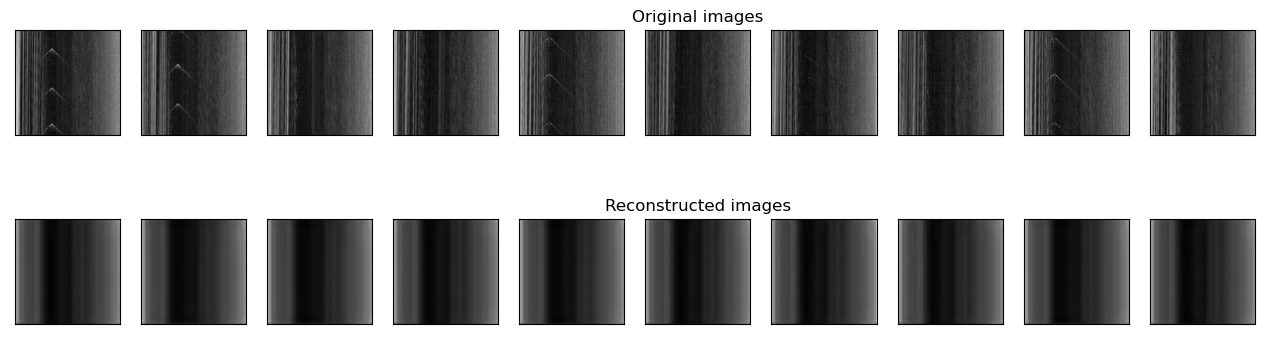

EPOCH 90 of 100 	 train loss 0.0005039325915277004 	 val loss 0.0004835970757994801


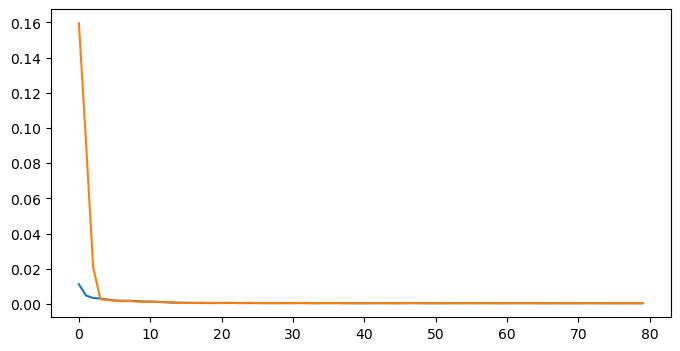

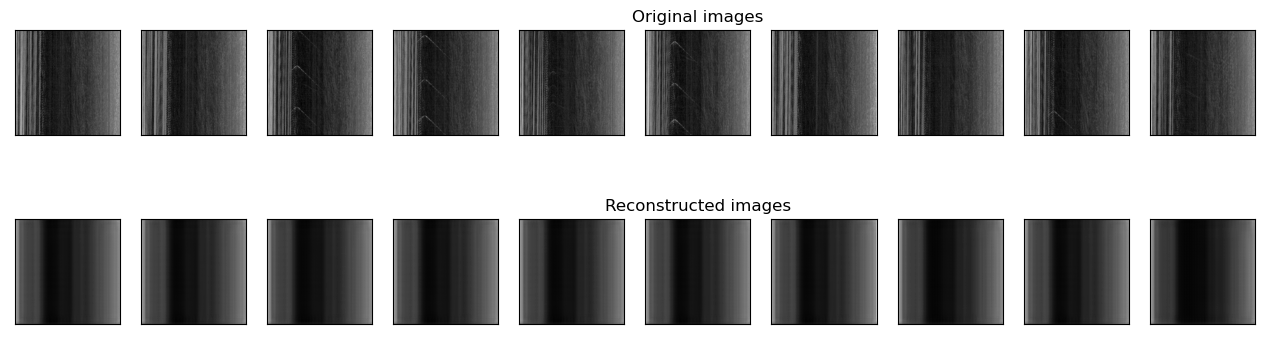

EPOCH 100 of 100 	 train loss 0.0005139003042131662 	 val loss 0.0004891053540632129


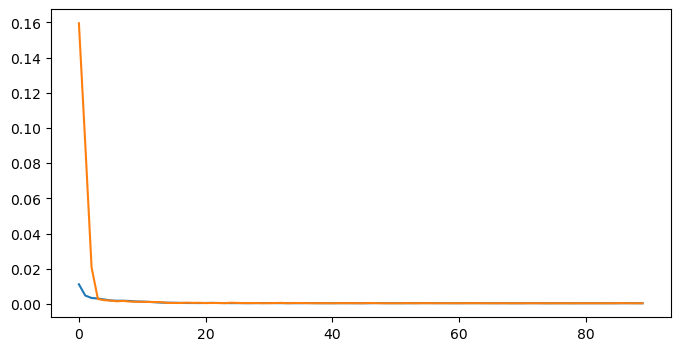

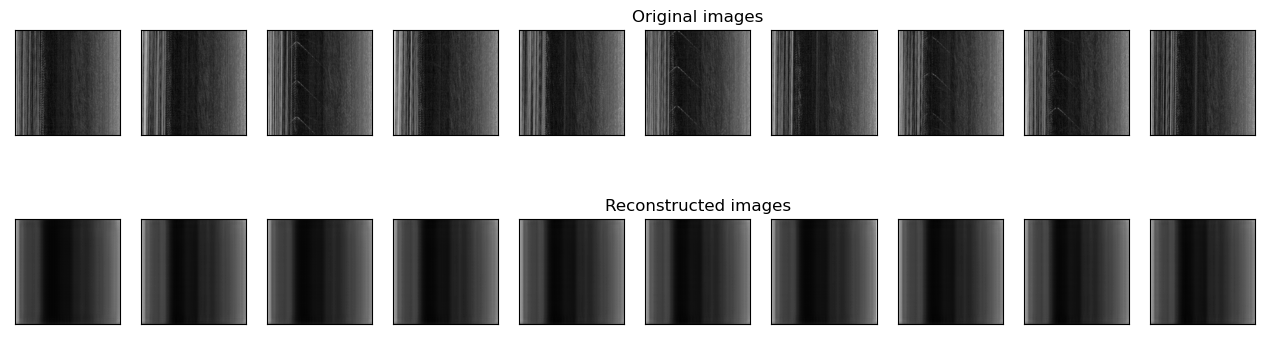

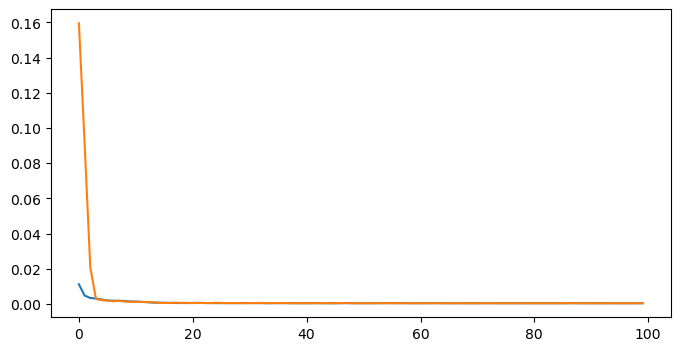

In [120]:
loss_fn = nn.MSELoss()
lr = 5e-3
encoded_space_dim = 32
fc2_input_dim = 512

encoder = Encoder(encoded_space_dim,fc2_input_dim).to(device)
decoder = Decoder(encoded_space_dim,fc2_input_dim).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)

num_epochs = 100

diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,train_dataloader,loss_fn,optimizer,verbose=False)
   val_loss = test_epoch(encoder,decoder,device,test_dataloader,loss_fn)
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)

   if (epoch+1) % 10 == 0:
      print('EPOCH {} of {} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
      plot_ae_outputs(encoder,decoder,test_dataset,n=10)
      plt.figure(figsize=(8,4))
      plt.plot(diz_loss['train_loss'],label='train loss')
      plt.plot(diz_loss['val_loss'],label='val loss')

The model seems to be a poor choice to pick out subtle patterns of the finwhale calls in the images. Perhaps the quality of data needs to be improved somehow or the detection task needs to be modified.

Some ideas:
- Use images with smaller distance and time intervals with the same model
- Us the paper's approach of going channel by channel by selecting high quality signals and applying encoder/decoder architrcture on it
- Use limited annotated data and build a weak classifier that can be gradually improved by annotating and validating its predictions - time consuming
- Apply an object detection type problem - time consuming
- Use a pre-trained model to encode the image and then train a decoder

In [ ]:
@torch.no_grad()
def visualize_conv_kernel(conv_layer, channel=0, nrow=8): 
    # source: https://github.com/pedrodiamel/nettutorial/blob/master/pytorch/pytorch_visualization.ipynb
    kernel = conv_layer.weight
    n, c, w, h = kernel.shape
    kernel = kernel[:, channel:channel+1, :, :]
    rows = np.min((kernel.shape[0]//nrow + 1, 64))    
    grid = make_grid(kernel, nrow=nrow, normalize=True, padding=1)
    plt.figure(figsize=(nrow,rows))
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))

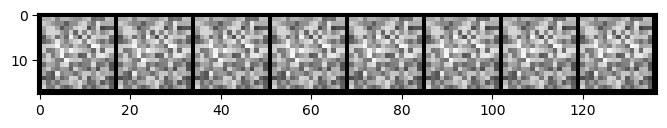

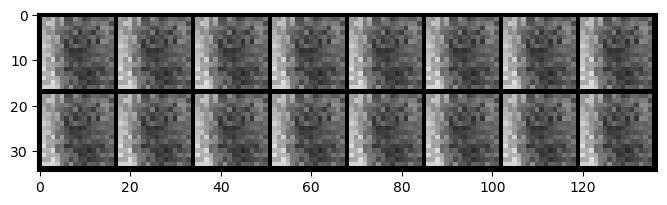

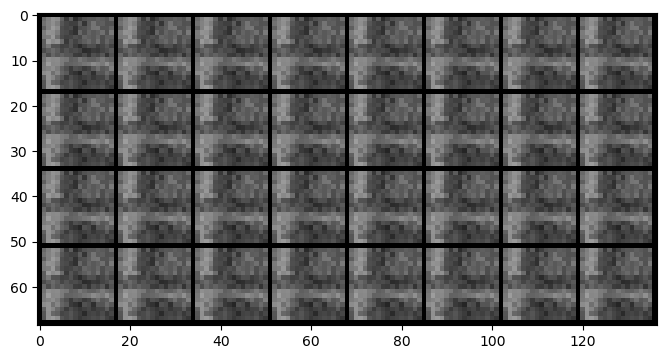

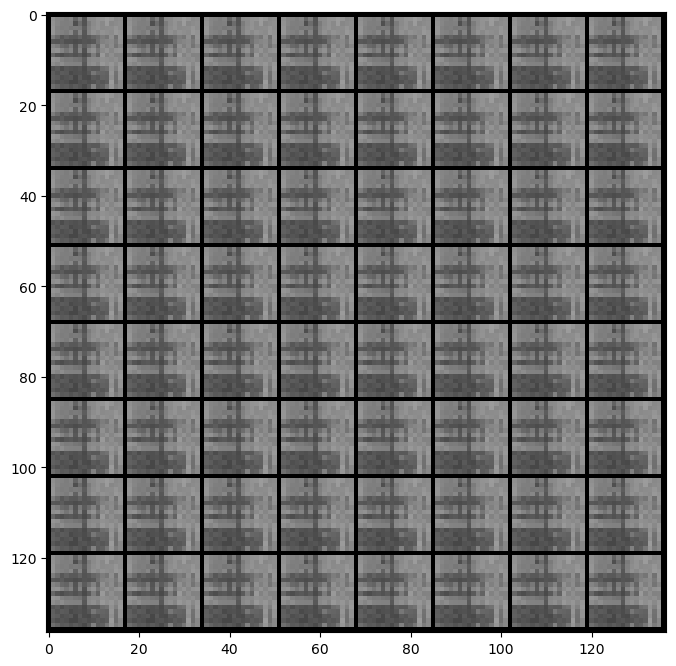

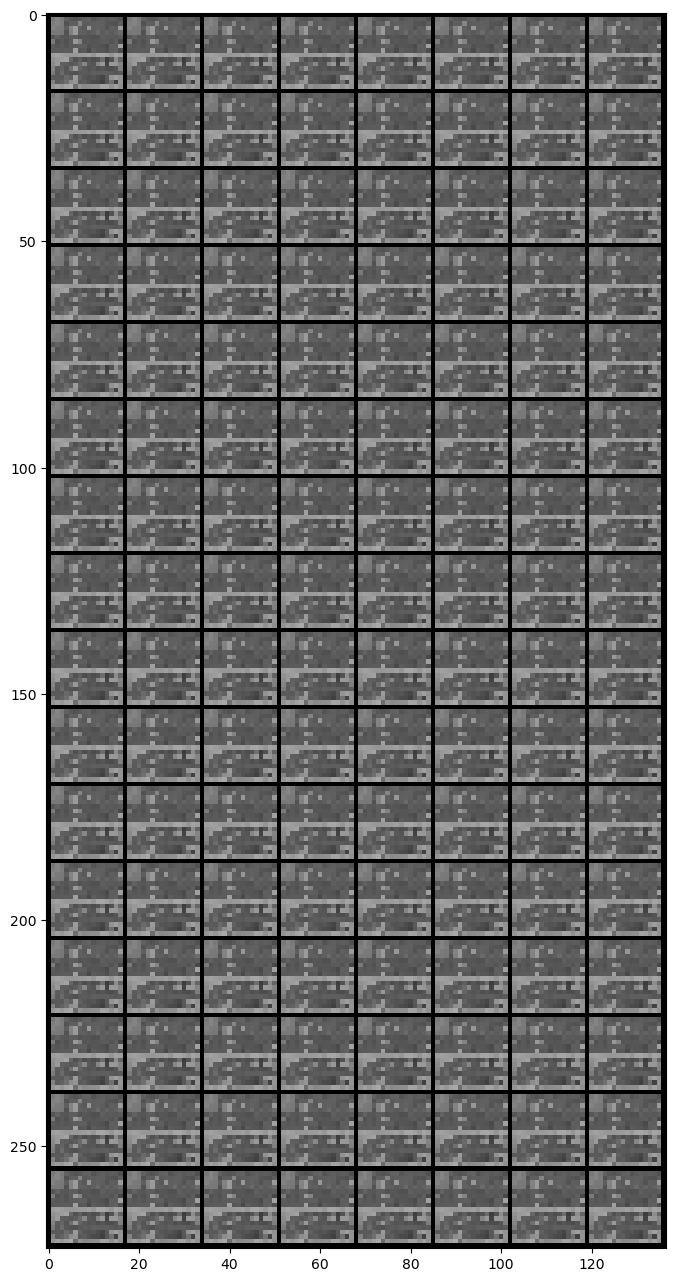

In [121]:
for layer in encoder.encoder_cnn:
    if type(layer) == nn.Conv2d:
        visualize_conv_kernel(layer, channel=0, nrow=8)

Need to look into why the convolution filters look very similar in each layer and what can be done about this.